<h1 style="text-align:center;">2024 Six Nations Drama:<br> Analyzing YouTube Reactions to Try Decision <br>Did France Deserve the Win or Was Scotland Robbed?</h1>

<p style="text-align:center; font-size:large;">Created By: Christopher Castor</p>

## Overview
The 2024 Six Nations rugby match between Scotland and France delivered a gripping and controversial moment in the final seconds, where an inconclusive last-gasp try review determined the outcome. As on-field referee Nic Berry called no-try despite potential evidence suggesting otherwise, the match concluded with France holding on to a tense victory. This pivotal decision has sparked widespread discussions and debates among rugby enthusiasts and fans.

This Jupyter notebook seeks to explore and analyze public sentiment surrounding this contentious last-minute call using the comments section of the [official Six Nations YouTube highlight video](https://www.youtube.com/watch?v=Rcst-jIOQDo). The goal is to determine whether the majority of viewers agree with the no-try decision by leveraging OpenAI and sentiment analysis techniques. 

## Table of Contents

- <a href='#1'> 1. Import Libraries</a>
- <a href='#2'> 2. Define Functions</a>
- <a href='#3'> 3. Retrieve and Clean Data</a>
- <a href='#4'> 4. Determine Sentiment</a>
- <a href='#5'> 5. Summary Statistics</a>
- <a href='#6'> 6. Sentiment Distribution</a>
- <a href='#7'> 7. Word Clouds</a>
- <a href='#8'> 8. Summarize Confident Decisions</a>

# <a id='1'>1. Import Libraries</a>

In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
from collections import Counter

# Import api libraries
from googleapiclient.discovery import build
from openai import OpenAI

# Import natural language processing (nlp)
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import html

# Import visualization libraries
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-dark')
import seaborn as sns
from wordcloud import WordCloud

# Load spaCy model with TextBlob capabilities
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("spacytextblob")
nltk.download('vader_lexicon')

# Import API Key and Video ID
load_dotenv()
api_key = os.getenv('API_KEY')
video_id = os.getenv('VIDEO_ID')

# Initialize OpenAI client
client = OpenAI(api_key = os.getenv('OPENAI_KEY'))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/christophercastor/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# <a id='2'>2. Define Functions</a>

In [2]:
def generate_decision(prompt):
    '''
    Generate a decision using OpenAI's chat model.

    Parameters:
    - prompt (str): The input prompt for the chat model.

    Returns:
    - decision (str): The generated decision based on the prompt.
    '''
    # Create chat completion with the given prompt
    response = client.chat.completions.create(
        model = "gpt-3.5-turbo-0125",
        messages=[{'role':'user', 'content':prompt}]
    )

    decision = response.choices[0].message.content

    return decision

In [3]:
def get_decisions(comment):
    '''
    Generate decisions for a comment using OpenAI's chat model.

    Parameters:
    - comment (str): The main comment for which a decision is generated.

    Returns:
    - comment_decision (str): The generated decision and confidence for the comment.
    '''
    # Generate decision for the comment
    comment_prompt = common_prompt + '\n\n"' + comment + '"'
    comment_decision = generate_decision(comment_prompt)

    return comment_decision

In [4]:
def clean_text(text):
    '''
    Clean and decode HTML entities from the input text.

    Parameters:
    - text (str): The text to be cleaned.

    Returns:
    - html.unescape(text) (str): The text after cleaning and decoding HTML entities.
    '''
    return html.unescape(text)

In [5]:
def video_reactions(video_id, api_key):
	'''
	Retrieve comments data for a YouTube video.

	Parameters:
	- video_id (str): The YouTube video ID.
	- api_key (str): The YouTube Data API key.

	Returns:
	- df (DataFrame): DataFrame containing comments and likes.
	'''
	# Create a list to store comments and related information
	comments_data = []

	# Create YouTube resource object
	youtube = build('youtube', 'v3', developerKey=api_key)

	# Retrieve YouTube video comments
	video_response=youtube.commentThreads().list(
	part='snippet',
	videoId=video_id
	).execute()

	# Iterate through video comments
	while video_response:
	
		# Extract information from each object
		for item in video_response['items']:
		
			# Extract comment text
			comment_text = item['snippet']['topLevelComment']['snippet']['textDisplay']
			
			# Extract number of likes for each comment
			likes_count = item['snippet']['topLevelComment']['snippet']['likeCount']

			# Append information to the list
			comments_data.append({'Comment': comment_text, 'Like_Count': likes_count})

		# Repeat for the next page if available
		if 'nextPageToken' in video_response:
			video_response = youtube.commentThreads().list(
					part = 'snippet',
					videoId = video_id,
					pageToken = video_response['nextPageToken']
				).execute()
		else:
			break

	# Create DataFrame containing comments and related information
	df = pd.DataFrame(comments_data)

	return df

In [6]:
def generate_distribution(counts, percentages, color, title):
    '''
    Generate a bar plot to visualize the distribution of categories.

    Parameters:
    - counts (pd.Series): Series containing counts for each category.
    - percentages (list): List of percentage values corresponding to each category.
    - color (str): Color of the bars in the plot.
    - title (str): Title of the plot.

    Returns:
    None (Displays the plot).
    '''
    # Create a new figure and axis
    fig, ax = plt.subplots()

    # Create bars for each category with the specified color
    bars = ax.bar(counts.index, counts, color=color)

    # Add percentage labels above each bar
    for bar, percentage in zip(bars, percentages):
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{percentage: .1f}%', ha='center', va='bottom', weight='bold')

    # Set the title of the plot
    ax.set_title(title, fontsize=14, fontweight='bold', y=1.05)

    # Display the plot
    return plt.show()

In [7]:
def calculate_average_sentiment(df, col):
    '''
    Calculate the average sentiment score for a specified column in a DataFrame.

    Parameters: 
    - df (DataFrame): Input DataFrame containing the text data.
    - col (str): Name of the column in the DataFrame containing the text data.

    Returns:
    - average_sentiment (float): Average sentiment score for the specified column.
    '''
    # Ensure the specified column exists in the DataFrame
    if col not in df.columns:
        raise ValueError(f"Column '{col}' does not exist")
    
    # Initialize the VADER sentiment analyzer
    sid = SentimentIntensityAnalyzer()

    # Process each text in the column
    sentiment_scores = []
    for text in df[col]:
        # Tokenize the text using spaCy
        doc = nlp(text)

        # Calculate sentiment score using NLTK VADER 
        compound_score = sid.polarity_scores(text)['compound']
        sentiment_scores.append(compound_score)

    # Calculate the average sentiment score
    average_sentiment = sum(sentiment_scores)/len(sentiment_scores)
    return average_sentiment

In [8]:
def clean_text_word_cloud_word(text):
    '''
    Tokenize and clean the input text for word cloud generation.

    Parameters:
    - text (str): Input text to be processed

    Returns:
    - cleaned_text (str): Cleaned and processed text suitable for word cloud generation.
    '''
    # Tokenize the input text using spaCy
    doc = nlp(text)

    # Initialize the VADER sentiment analyzer
    sid = SentimentIntensityAnalyzer()

    # Extract tokens, excluding stopwords and non-alphabetic tokens
    cleaned_tokens = [token.text.lower() for token in doc if (
        (token.text.lower() in ['robbed']) or (
        not token.is_stop and 
        token.is_alpha and 
        (sid.polarity_scores(token.text)['compound'] != 0))
        )]
    
    # Join the cleaned tokens into a single string
    cleaned_text = ' '.join(cleaned_tokens)

    # Return the cleaned and processed text
    return cleaned_text

In [9]:
def generate_word_cloud(comments, title, stopwords=None):
    '''
    Generate a word cloud from a list of comments.

    Parameters:
    - comments (list): List of text comments.
    - title (str): Title for the word cloud plot.
    - stopwords (set): Set of stop words to be excluded from the word cloud.

    Returns:
    None (Displays the word cloud plot)
    '''
    # Clean the comments
    cleaned_comments = [clean_text_word_cloud_word(comment) for comment in comments]

    # Create a WordCloud object with specified parameters
    if stopwords:
        wordcloud = WordCloud(width=800, height=400, max_words=1000, background_color='white', stopwords=stopwords).generate(' '.join(cleaned_comments))
    else:
        wordcloud = WordCloud(width=800, height=400, max_words=1000, background_color='white').generate(' '.join(cleaned_comments))
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

    # Set the title of the plot
    plt.title(title, fontsize=18, fontweight='bold', y=1.05)

    # Return the word cloud plot
    return plt.show()

# <a id='3'>3. Retrieve and Clean Data</a>

In [10]:
# Retrieve comments and likes from the YouTube video
reaction_df = video_reactions(video_id, api_key)

# Clean text in the 'Comment' column
reaction_df['Comment'] = reaction_df['Comment'].apply(clean_text)

# <a id='4'>4. Determine Sentiment</a>

In [11]:
common_prompt = '''
Scotland were denied victory by an inconclusive last-second try review as France held on to win a tense Six Nations rugby encounter. Replays suggested the ball was grounded by Sam Skinner but the on-field referee, Nic Berry, called no try and the Television Match Official (TMO), claimed to not have the evidence to conclusively prove otherwise. Fan's either agree with the referees' decision of no try, implying that the fan believes the ball was lost and the referees did a good job and France deservedly won ('Agree') OR fan's disagree with the decision of no try, implying that the fan is upset and the ball was grounded and touched the ground and it was a clear try and the referees did a bad job and Scotland was robbed and deserved to win ('Disagree'). Read a fan's statement below and use the criteria above to choose 'Agree' or 'Disagree' and provide a confidence level between 1-5, where 1 means you have low confidence and 5 is high confidence. Separate the word and number with a colon. So your reply should be in the format, word:number.
'''

# Generate decisions for each comment
reaction_df['OpenAI_Response'] = reaction_df['Comment'].apply(get_decisions)

# Clean returned OpenAI response
reaction_df['OpenAI_Response'] = reaction_df['OpenAI_Response'].astype(str).replace(to_replace = r'[. ]', value='', regex=True)

# Split into decision and confidence
reaction_df[['Comment_Decision','Comment_Decision_Confidence']] = reaction_df['OpenAI_Response'].str.split(':', expand=True)

# Clean the decision column
reaction_df['Comment_Decision'] = np.where(~reaction_df['Comment_Decision'].isin(['Agree','Disagree']),'Disagree',reaction_df['Comment_Decision'])

# Clean the confidence column
reaction_df['Comment_Decision_Confidence'] = reaction_df['Comment_Decision_Confidence'].fillna(np.NaN).astype(str).str[:1]
reaction_df['Comment_Decision_Confidence'] = np.where(reaction_df['Comment_Decision_Confidence']=='n',1,reaction_df['Comment_Decision_Confidence']).astype(int)

# Save DataFrame to data folder
reaction_df.to_csv('./data/sentiment_results.csv', index=False)

# <a id='5'>5. Summary Statistics</a>

In [12]:
print(f'Comments: {len(reaction_df)}, Likes: {reaction_df['Like_Count'].sum()}')
print('')
print('Most Liked Comments')
for index, row in reaction_df.sort_values(by='Like_Count', ascending=False).head().iterrows():
    print(f'Comment: {row['Comment']}, Likes: {row['Like_Count']}, Sentiment: {row['OpenAI_Response']}')

Comments: 451, Likes: 4172

Most Liked Comments
Comment: Like if Scotland were robbed, Likes: 1383, Sentiment: Disagree:4
Comment: As a frenchman, used to being cheated, I must say it's sad to win this way. The last try seemed valid. Sorry my Scottish friends, totally undeserved defeat for you., Likes: 433, Sentiment: Disagree:4
Comment: Frenchman here . Finn russell is a real gentleman smiling to the french while being robbed and shaking hands . Wonderful player wonderful spirit. NO ENGLISHMAN WOULD DO THAT, that's why we love Scotland !, Likes: 387, Sentiment: Disagree:4
Comment: On behalf of many, many French supporters, I would like to apoligise for the outcome of this match and obviously this isn't going to compensate for anything:  Of course there was a try. Nobody here is celebrating! It's a shameful victory! Secondly, what a crowd you guys are!  I was already a huge fan of your team and supporters, but the reaction of the crowd and the respectful manner in which they had to acc

In [13]:
print(f'Comments Sentiment > Agree: {len(reaction_df[reaction_df['Comment_Decision']=='Agree'])}, Disagree: {len(reaction_df[reaction_df['Comment_Decision']=='Disagree'])}')
print(f'Likes Sentiment > Agree: {reaction_df[reaction_df['Comment_Decision']=='Agree']['Like_Count'].sum()}, Disagree: {reaction_df[reaction_df['Comment_Decision']=='Disagree']['Like_Count'].sum()}')
print(f'OpenAI Confidence > 1: {len(reaction_df[reaction_df['Comment_Decision_Confidence']==1])}, 1: {len(reaction_df[reaction_df['Comment_Decision_Confidence']==1])}, 2: {len(reaction_df[reaction_df['Comment_Decision_Confidence']==2])}, 3: {len(reaction_df[reaction_df['Comment_Decision_Confidence']==3])}, 4: {len(reaction_df[reaction_df['Comment_Decision_Confidence']==4])}, 5: {len(reaction_df[reaction_df['Comment_Decision_Confidence']==5])}')

Comments Sentiment > Agree: 84, Disagree: 367
Likes Sentiment > Agree: 170, Disagree: 4002
OpenAI Confidence > 1: 0, 1: 0, 2: 4, 3: 78, 4: 350, 5: 19


In [14]:
average_sentiment_agree = round(calculate_average_sentiment(reaction_df[reaction_df['Comment_Decision']=='Agree'].reset_index(drop=True), 'Comment'),2)
average_sentiment_disagree = round(calculate_average_sentiment(reaction_df[reaction_df['Comment_Decision']=='Disagree'].reset_index(drop=True), 'Comment'),2)

print('Sentiment scores from VADER range from -1 to 1')
print('Negative: Less than 0, Neutral: Equal to 0, Positive: More than 0')
print('')
print(f"Average Sentiment for Agree: {average_sentiment_agree}")
print(f"Average Sentiment for Disagree: {average_sentiment_disagree}")

Sentiment scores from VADER range from -1 to 1
Negative: Less than 0, Neutral: Equal to 0, Positive: More than 0

Average Sentiment for Agree: 0.14
Average Sentiment for Disagree: 0.03


# <a id='6'>6. Sentiment Distribution</a>

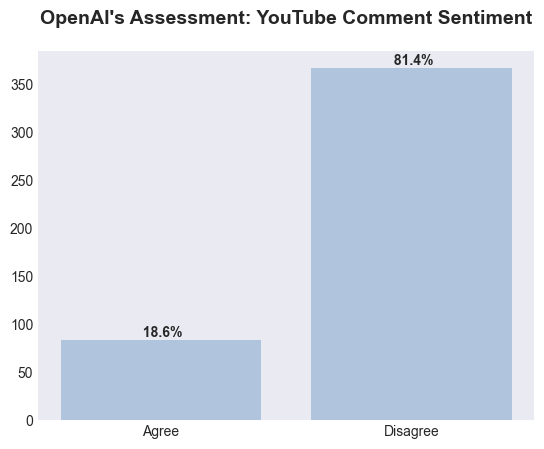

In [15]:
# Calculate distribution of YouTube comment sentiment
comment_counts = reaction_df['Comment_Decision'].value_counts().sort_index()
comment_percentages = (comment_counts / len(reaction_df)) * 100
generate_distribution(comment_counts, comment_percentages, 'lightsteelblue', "OpenAI's Assessment: YouTube Comment Sentiment")

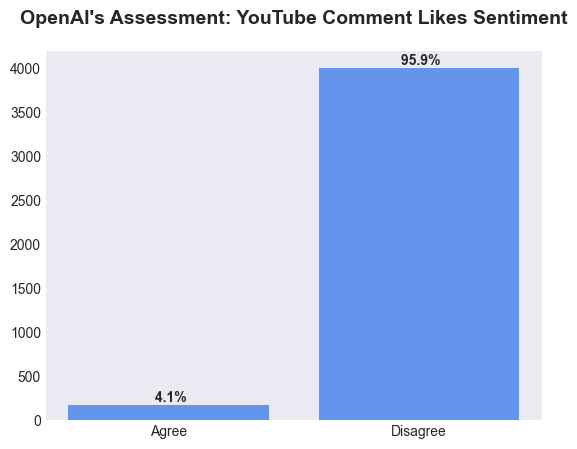

In [16]:
# Calculate distribution of YouTube comment likes sentiment
like_counts = reaction_df['Like_Count'].groupby(reaction_df['Comment_Decision']).sum().sort_index()
like_percentages = (like_counts / (reaction_df['Like_Count'].groupby(reaction_df['Comment_Decision']).sum()).sum()) * 100
generate_distribution(like_counts, like_percentages, 'cornflowerblue', "OpenAI's Assessment: YouTube Comment Likes Sentiment")

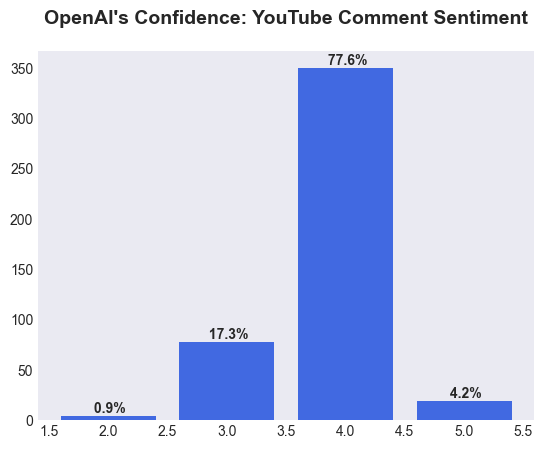

In [19]:
# Calculate distribution of OpenAI's confidence on sentiment
confidence_counts = reaction_df['Comment_Decision_Confidence'].value_counts().sort_index()
confidence_percentages = (confidence_counts / len(reaction_df)) * 100
generate_distribution(confidence_counts, confidence_percentages, 'royalblue', "OpenAI's Confidence: YouTube Comment Sentiment")

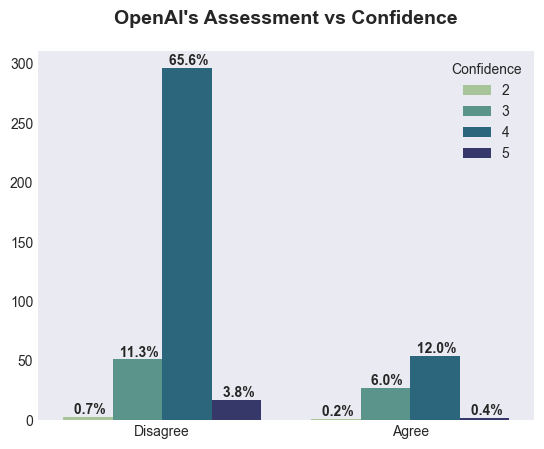

In [20]:
# Create grouped bar chart showing OpenAI's assessment vs confidence
ax = sns.countplot(data=reaction_df, x='Comment_Decision', hue='Comment_Decision_Confidence', palette="crest")
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title("OpenAI's Assessment vs Confidence", fontsize=14, fontweight='bold', y=1.05)
ax.legend(title='Confidence')

# Add percentages above bar
total = len(reaction_df)
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width() / 2., height + 0.1, f'{height/total: .1%}', ha='center', va='bottom', weight='bold')

# Show chart
plt.show()

# <a id='7'>7. Word Clouds</a>

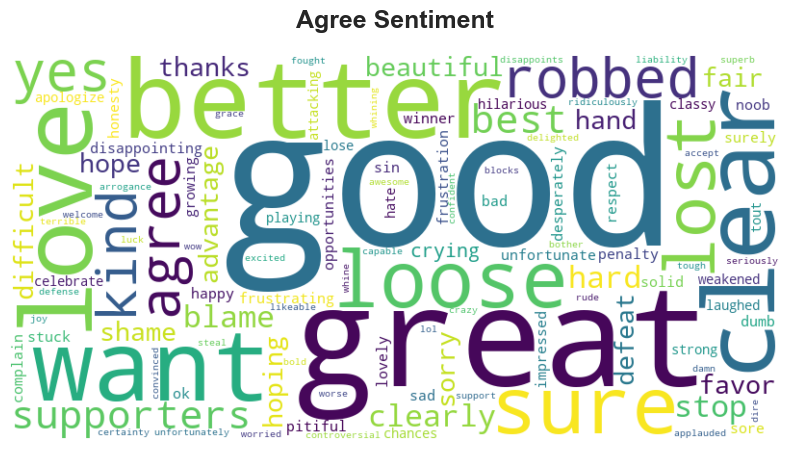

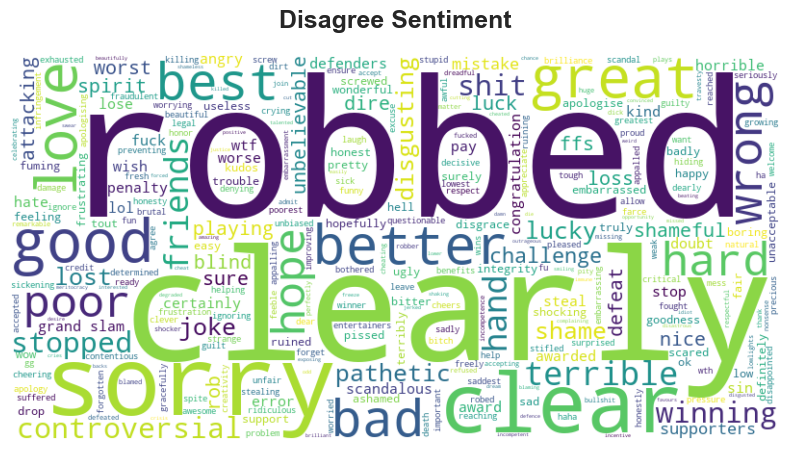

In [21]:
# Create stop words list
stopwords=['win','play','fan','supporter','like','played','won']

# Generate word clouds for each sentiment
generate_word_cloud(reaction_df[reaction_df['Comment_Decision']=='Agree']['Comment'], 'Agree Sentiment', stopwords)
generate_word_cloud(reaction_df[reaction_df['Comment_Decision']=='Disagree']['Comment'], 'Disagree Sentiment', stopwords)

# <a id='8'>8. Summarize Confident Decisions</a>

In [22]:
# Use OpenAI to summarize the most confident Agree comments
confident_agree_comments = reaction_df[(reaction_df['Comment_Decision_Confidence']>=4)&(reaction_df['Comment_Decision']=='Agree')].sort_values(by='Like_Count', ascending=False).head(50)['Comment'].str.cat(sep='\n')
generate_decision('Summarize these comments using 3 sentences. \n\n' + confident_agree_comments)

'French fans are happy about the favorable referee decision, while some believe that Scotland had their chances and should not blame the officials. Many feel that the decision to not award the try was correct due to lack of clear evidence of grounding. Overall, the game was seen as hard-fought and controversial, with some acknowledging that the rules were followed despite frustrations.'

In [23]:
# Use OpenAI to summarize the most confident Disagree comments
confident_disagree_comments = reaction_df[(reaction_df['Comment_Decision_Confidence']>=4)&(reaction_df['Comment_Decision']=='Disagree')].sort_values(by='Like_Count', ascending=False).head(50)['Comment'].str.cat(sep='\n')
generate_decision('Summarize these comments using 3 sentences. \n\n' + confident_disagree_comments)

'Many viewers felt that Scotland was robbed of a victory in the match against France, with some even admitting that it was a clear try for Scotland. Fans from various countries expressed disappointment with the outcome of the game and criticized the officiating. Despite the controversy, many praised the sportsmanship shown by Scotland and the respectful manner in which they accepted the defeat.'